For demo, see the throw.ipynb

Autoformer

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
class TimeSeriesWindowDataset(Dataset):
    def __init__(self, df, context_length, prediction_length, lags_sequence):
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.lags_sequence = lags_sequence
        self.max_lag = max(lags_sequence)
        self.required_past_length = context_length + self.max_lag

        self.values = df['requests'].values
        self.features = df[['memory', 'cpu']].values

        self.length = len(df) - self.required_past_length - prediction_length + 1

        self.static_real = np.array([df['cpu'].mean(), df['memory'].mean()])
        self.static_cat = np.array([0])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # extract values
        past_values = self.values[idx : idx + self.required_past_length]
        future_values = self.values[idx + self.required_past_length : idx + self.required_past_length + self.prediction_length]
        
        # compute mean and std for normalization (per sample)
        mean = past_values.mean()
        std = past_values.std()
        std = std if std > 0 else 1.0

        # normalize both past and future values
        norm_past_values = (past_values - mean) / std
        norm_future_values = (future_values - mean) / std

        past_time_features = self.features[idx : idx + self.required_past_length]
        future_time_features = self.features[idx + self.required_past_length : idx + self.required_past_length + self.prediction_length]

        past_observed_mask = ~np.isnan(past_values)
        future_observed_mask = ~np.isnan(future_values)

        return {
            'past_values': torch.tensor(norm_past_values, dtype=torch.float),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.float),
            'future_values': torch.tensor(norm_future_values, dtype=torch.float),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float),
            'future_observed_mask': torch.tensor(future_observed_mask, dtype=torch.float),
            'static_real_features': torch.tensor(self.static_real, dtype=torch.float),
            'static_categorical_features': torch.tensor(self.static_cat, dtype=torch.long),
            'norm_mean': torch.tensor(mean, dtype=torch.float),  # add this
            'norm_std': torch.tensor(std, dtype=torch.float)
        }


In [3]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [4]:
lags_seq = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # can include 0 if needed
context_len = 11  # 21 - max(lags_seq)
prediction_len = 2 # prediction Length


In [5]:
dataset = TimeSeriesWindowDataset(df, context_length=context_len, prediction_length=prediction_len, lags_sequence=lags_seq)

In [6]:
loader = DataLoader(dataset, batch_size=64, shuffle=True)
for batch in loader:
    print("past values:", batch['past_values'].shape, end="\n")  
    print("past_time_features: ",batch['past_time_features'].shape, end="\n") 
    print("past_observed_mask: ",batch['past_observed_mask'].shape, end="\n")
    print("future_values: ",batch['future_values'].shape, end="\n") 
    print("future_time_series: ",batch['future_time_features'].shape, end="\n") 
    print("future_observed_mask: ",batch['future_observed_mask'].shape, end="\n") 
    break


past values: torch.Size([64, 21])
past_time_features:  torch.Size([64, 21, 2])
past_observed_mask:  torch.Size([64, 21])
future_values:  torch.Size([64, 2])
future_time_series:  torch.Size([64, 2, 2])
future_observed_mask:  torch.Size([64, 2])


MODEL CONFIGURATION

In [7]:
from transformers import AutoformerForPrediction, AutoformerConfig
config = AutoformerConfig(
    context_length=context_len,
    prediction_length=prediction_len,
    lags_sequence=lags_seq,
    input_size=1,
    num_time_features=2,
    static_categorical_cardinalities=[1],
    static_real_features=2,
)

model = AutoformerForPrediction(config)

/home/suraj/projects/time_series/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 50  #

Training Part

In [10]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in loader:
        # Move batch tensors to the same device as model
        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_values=batch['future_values'],
            future_time_features=batch['future_time_features'],
            # static_real_features=batch['static_real_features'],
            # static_categorical_features=batch['static_categorical_features']
        )

        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")

Epoch 1/50, Loss: 187.0361
Epoch 2/50, Loss: 181.9511
Epoch 3/50, Loss: 181.0106
Epoch 4/50, Loss: 180.4361
Epoch 5/50, Loss: 180.1931
Epoch 6/50, Loss: 180.0121
Epoch 7/50, Loss: 179.3545
Epoch 8/50, Loss: 179.3590
Epoch 9/50, Loss: 178.8836
Epoch 10/50, Loss: 178.9220
Epoch 11/50, Loss: 178.5252
Epoch 12/50, Loss: 177.9073
Epoch 13/50, Loss: 177.6373
Epoch 14/50, Loss: 177.3902
Epoch 15/50, Loss: 176.9390
Epoch 16/50, Loss: 176.9230
Epoch 17/50, Loss: 176.7854
Epoch 18/50, Loss: 175.7766
Epoch 19/50, Loss: 175.5107
Epoch 20/50, Loss: 175.7436
Epoch 21/50, Loss: 175.4253
Epoch 22/50, Loss: 175.3168
Epoch 23/50, Loss: 175.5395
Epoch 24/50, Loss: 174.3516
Epoch 25/50, Loss: 174.1704
Epoch 26/50, Loss: 175.0445
Epoch 27/50, Loss: 173.8960
Epoch 28/50, Loss: 174.5228
Epoch 29/50, Loss: 173.9827
Epoch 30/50, Loss: 173.0953
Epoch 31/50, Loss: 173.6200
Epoch 32/50, Loss: 172.6991
Epoch 33/50, Loss: 172.4786
Epoch 34/50, Loss: 172.7246
Epoch 35/50, Loss: 172.8236
Epoch 36/50, Loss: 172.0261
E

Evaluation Part

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Avoid division by zero in MAPE
    nonzero_mask = y_true != 0
    if np.any(nonzero_mask):
        mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
    else:
        mape = float('inf')

    return {
        'MSE': round(mse, 4),
        'RMSE': round(rmse, 4),
        'MAE': round(mae, 4),
        'MAPE': round(mape, 4),
        'R2': round(r2, 4)
    }


Evaluation on Single batch

In [12]:
model.eval()

# Grab a batch
for batch in loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    break

# Generate predictions
with torch.no_grad():
    outputs = model.generate(
        past_values=batch['past_values'],
        past_time_features=batch['past_time_features'],
        past_observed_mask=batch['past_observed_mask'],
        future_time_features=batch['future_time_features'],
        # static_real_features=batch['static_real_features'],  # if you're using these
        # static_categorical_features=batch['static_categorical_features'],
    )

normalized_forecast = outputs.sequences  

loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

scale[scale == 0] = 1.0

rescaled_forecast = normalized_forecast * scale + loc

first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
true_values = batch['future_values']


true_values.cpu()
first_pred.cpu()
# print("Ground truth:\n", true_values)
print(evaluate_forecast(true_values.cpu().numpy(), first_pred.cpu().numpy()))

{'MSE': 3.382, 'RMSE': 1.839, 'MAE': 1.3673, 'MAPE': 1150.3598, 'R2': -1.5709}


Evaluation on entire dataset I

In [13]:
# model.eval()
# all_y_true = []
# all_y_pred = []

# with torch.no_grad():
#     for batch in loader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         # print("past values:", batch['past_values'], end="\n")
#         outputs = model.generate(
#             past_values=batch['past_values'],
#             past_time_features=batch['past_time_features'],
#             past_observed_mask=batch['past_observed_mask'],
#             future_time_features=batch['future_time_features'],
#         )

#         # normalized_forecast = outputs.sequences

#         # loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)
#         # scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)
#         # scale[scale == 0] = 1.0

#         # rescaled_forecast = normalized_forecast * scale + loc
#         first_pred = outputs.sequences[:, 0, :]
#         # First-step forecast


#         all_y_true.append(batch['future_values'].cpu().numpy())
#         # print("True values: ",batch['future_values'].cpu().numpy(), end="\n")
#         all_y_pred.append(first_pred.cpu().numpy())


# # Flatten all results
# y_true = np.concatenate(all_y_true).flatten()
# y_pred = np.concatenate(all_y_pred).flatten()


# print("y_true:", y_true)




# # Evaluate
# metrics = evaluate_forecast(y_true, y_pred)
# # print("Evaluation Metrics (Autoformer Model):", metrics)


Evaluation on Entire Dataset II

In [14]:
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model.generate(
            past_values=batch['past_values'],
            past_time_features=batch['past_time_features'],
            past_observed_mask=batch['past_observed_mask'],
            future_time_features=batch['future_time_features'],
        )

        normalized_forecast = outputs.sequences

        # De-normalize using saved mean and std
        mean = batch['norm_mean'].unsqueeze(-1).unsqueeze(-1)
        std = batch['norm_std'].unsqueeze(-1).unsqueeze(-1)
        rescaled_forecast = normalized_forecast * std + mean

        first_pred = rescaled_forecast[:, 0, :]

        all_y_true.append((batch['future_values'] * std.squeeze(-1) + mean.squeeze(-1)).cpu().numpy())
        all_y_pred.append(first_pred.cpu().numpy())


# Flatten all results
y_true = np.concatenate(all_y_true).flatten()
y_pred = np.concatenate(all_y_pred).flatten()


print("y_true:", y_true)




# Evaluate
metrics = evaluate_forecast(y_true, y_pred)

y_true: [162.       160.       120.       ...  62.000004   7.        10.      ]


In [15]:
print("Evaluation Metrics (Autoformer Model):", metrics)

Evaluation Metrics (Autoformer Model): {'MSE': 81561.9922, 'RMSE': 285.5906, 'MAE': 56.1061, 'MAPE': 46.3991, 'R2': -0.2501}


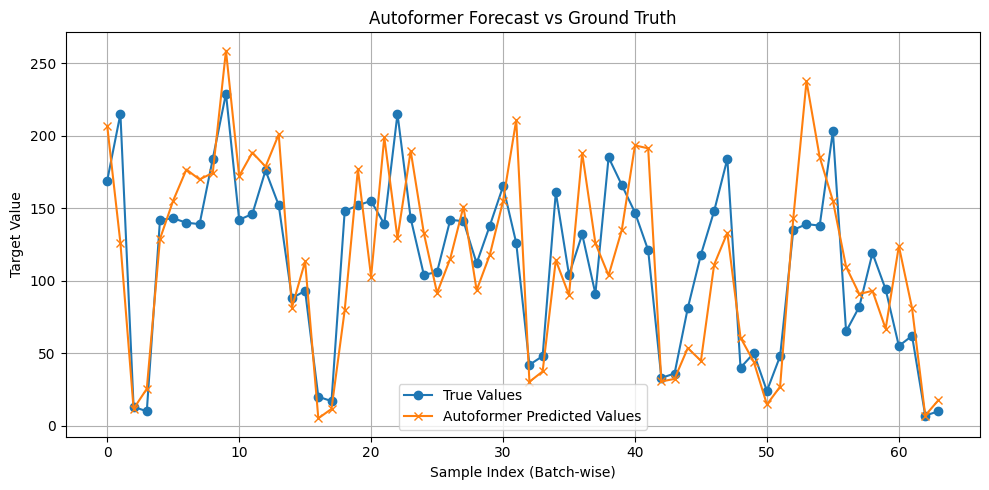

In [16]:
import matplotlib.pyplot as plt

# #single batch plotting
# y_true = true_values.cpu().numpy().flatten()
# y_pred = first_pred.cpu().numpy().flatten()

# entire dataset
y_true = y_true.flatten()
y_pred = y_pred.flatten()


# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true[-64:], label="True Values", marker='o')
plt.plot(y_pred[-64:], label="Autoformer Predicted Values", marker='x')
plt.title("Autoformer Forecast vs Ground Truth")
plt.xlabel("Sample Index (Batch-wise)")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Evaluation on a single batch

In [17]:
# model.eval()

# # Grab a batch
# for batch in loader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     break

# # Generate predictions
# with torch.no_grad():
#     outputs = model.generate(
#         past_values=batch['past_values'],
#         past_time_features=batch['past_time_features'],
#         past_observed_mask=batch['past_observed_mask'],
#         future_time_features=batch['future_time_features'],
#         # static_real_features=batch['static_real_features'],  # if you're using these
#         # static_categorical_features=batch['static_categorical_features'],
#     )

# normalized_forecast = outputs.sequences  

# loc = batch['past_values'].mean(dim=1, keepdim=True).unsqueeze(-1)   # [B, 1, 1]
# scale = batch['past_values'].std(dim=1, keepdim=True).unsqueeze(-1)  # [B, 1, 1]

# scale[scale == 0] = 1.0

# rescaled_forecast = normalized_forecast * scale + loc

# first_pred = rescaled_forecast[:, 0, :]  # [batch_size, 1]
# true_values = batch['future_values']


# true_values.cpu()
# first_pred.cpu()
# # print("Ground truth:\n", true_values)
# print(evaluate_forecast(true_values.cpu().numpy(), first_pred.cpu().numpy()))